<a href="https://colab.research.google.com/github/Nikichel/stylization/blob/main/stylization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy
from torchsummary import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [ ]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("/content/drive/MyDrive/Images/img_style.jpg")
content_img = image_loader("/content/drive/MyDrive/Images/img.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

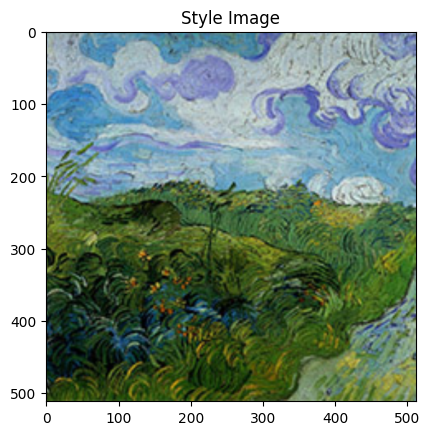

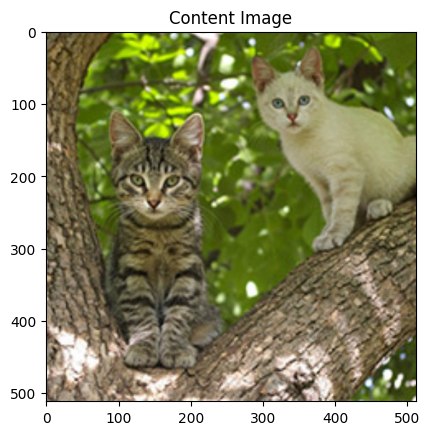

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
def gram_matrix(input):
  a, b, c, d = input.size()
  features = input.view(a * b, c * d)
  G = torch.mm(features, features.t())
  return G.div(a * b * c * d)

class StyleLoss(nn.Module):

  def __init__(self, target):
    super(StyleLoss, self).__init__()
    self.target_feature = gram_matrix(target).detach()

  def forward(self, input):
    input_features = gram_matrix(input)
    self.loss = F.mse_loss(input_features, self.target_feature)
    return input

In [ ]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [ ]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):

  normalization = Normalization(normalization_mean, normalization_std)

  content_losses =[]
  style_losses = []

  model = nn.Sequential(normalization)

  i = 0  # increment every time we see a conv
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else:
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)

    if name in content_layers:
      output = model(content_img).detach()
      content_loss = ContentLoss(output)
      model.add_module("content_loss_{}".format(i), content_loss)
      content_losses.append(content_loss)

    if name in style_layers:
      output = model(style_img).detach()
      style_loss = StyleLoss(output)
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)

  #print(model)

  for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break

  model = model[:(i + 1)]

  #print(model)

  return model, style_losses, content_losses

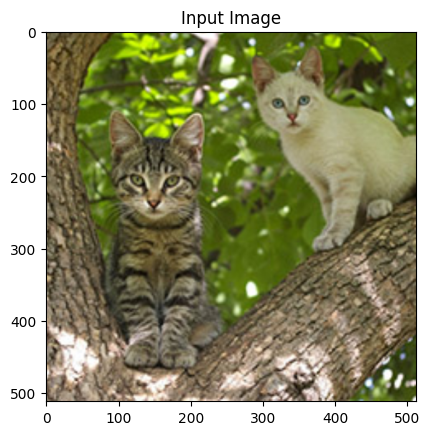

In [ ]:
input_img = content_img.clone()

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
def get_input_opt(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [ ]:
imgs = []

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=100000000, content_weight=1):

  model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)

  input_img.requires_grad_(True)

  model.requires_grad_(False)

  optimizer = get_input_opt(input_img)

  run = [0]

  while run[0] <= num_steps:

    def closure():
      with torch.no_grad():
        input_img.clamp_(0, 1)

      optimizer.zero_grad()

      model(input_img)

      style_score = 0
      content_score = 0

      for cl in content_losses:
        content_score += cl.loss
      for sl in style_losses:
        style_score += sl.loss

      style_score *= style_weight
      content_score *= content_weight

      loss = style_score + content_score

      #print(f"{style_score}, {content_score}, {loss}")
      loss.backward()

      if run[0] % 50 == 0:
        print("run {}:".format(run))
        print('Style Loss : {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
        print()
        imgs.append(input_img)

      run[0] += 1
      return style_score + content_score

    optimizer.step(closure)

  with torch.no_grad():
    input_img.clamp_(0, 1)

  return input_img

run [0]:
Style Loss : 234571.328125 Content Loss: 0.000000

run [50]:
Style Loss : 10899.052734 Content Loss: 14.616343

run [100]:
Style Loss : 2448.559814 Content Loss: 13.532291

run [150]:
Style Loss : 1052.088135 Content Loss: 13.892599

run [200]:
Style Loss : 633.377686 Content Loss: 14.667151

run [250]:
Style Loss : 413.464294 Content Loss: 15.379793

run [300]:
Style Loss : 267.260834 Content Loss: 16.015987



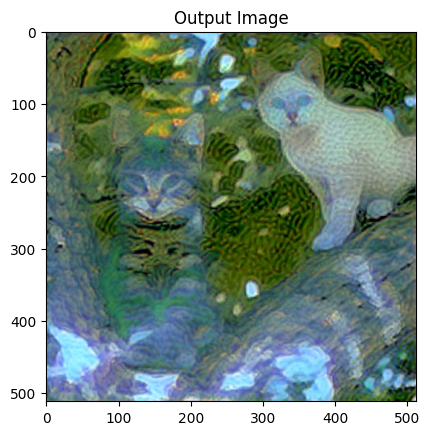

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

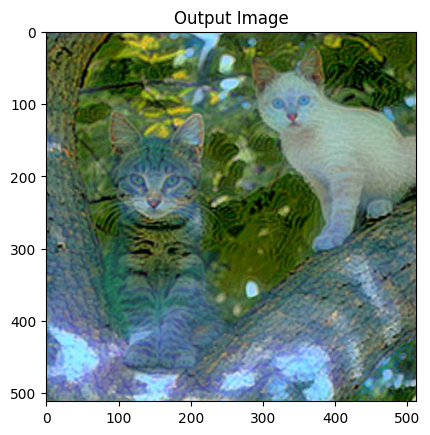

In [ ]:
plt.figure()
imshow(imgs[-1], title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()